In [5]:
#Installing all the packages
!pip3 install opencv-python
!pip3 install numpy
!pip3 install Pillow
!pip3 install matplotlib
!pip3 install scipy

In [6]:
#Importing all relevant packages
import os
import sys
import numpy as np
import cv2
import glob
import time
import math
from matplotlib import pyplot as plt
from scipy.ndimage import interpolation as inter
%matplotlib inline

In [7]:
#We will take advantage of PIL and glob to import all .jpg / .png / .jpeg
#images in a specified folder called 'inputFolder' you want to use 
#on average, for 100 images it will take 4ms

#Finds the current jupyter notebook file location and changes
#the directory to the /inputFolder directory
os.chdir(sys.path[0] + '/inputFolder')

#handles different image filetypes extensions
extensions = ['png', 'jpg', 'jpeg']

#creates a list with the names of the files we will use
imageList = []
[imageList.extend(glob.glob('*.' + e)) for e in extensions]

[None, None, None]

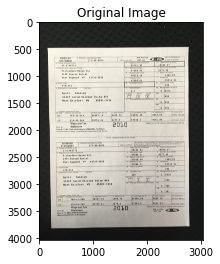

In [8]:
#Reads in image
#NOTE PLEASE READ
#plt.imshow works in RGB colors while cv2.imread makes an image
#BGR so every plt.imshow function will be converted to RGB

img = cv2.imread(imageList[1])
plt.title('Original Image')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

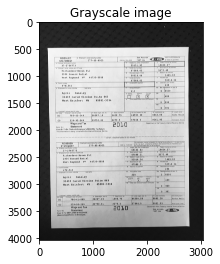

In [9]:
#Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.title('Grayscale image')
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

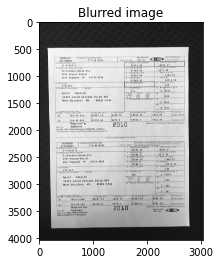

In [10]:
#Blur image
blur = cv2.GaussianBlur(gray, (3, 3), 0)
plt.title('Blurred image')
plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))

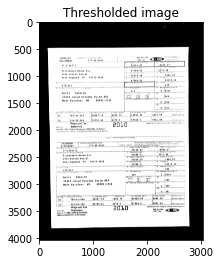

In [11]:
#Threshold using Binary and Otsu thresholding
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
plt.title('Thresholded image')
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))

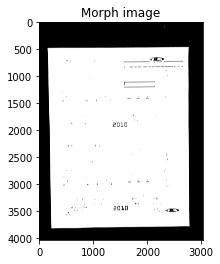

In [12]:
#Apply morphology to get rid of some text
kernel = np.ones((7, 7), np.uint8)
morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)
plt.title('Morph image')
plt.imshow(cv2.cvtColor(morph, cv2.COLOR_BGR2RGB))

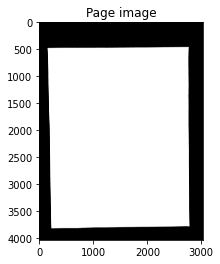

In [13]:
#Now find the contours on morphology image and makes everything
#on the page a 0 in nd array, getting rid of all extra information
#Big contour is c
contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
area_thresh = 0
for c in contours:
    area = cv2.contourArea(c)
    if area > area_thresh:
        area_thresh = area
        big_contour = c
page = np.zeros_like(img)
cv2.drawContours(page, [big_contour], 0, (255, 255, 255), -1)

plt.title('Page image')
plt.imshow(cv2.cvtColor(page, cv2.COLOR_BGR2RGB))

In [14]:
#Gets the approximated corners, from the biggest contour it found
peri = cv2.arcLength(big_contour, True)
corners = cv2.approxPolyDP(big_contour, 0.04 * peri, True)
print(corners)
print('-----------------')
print (corners[0][0])
print (corners[1][0])
print (corners[2][0])
print (corners[3][0])
print('Min-------------')
print(corners.min(axis=0))
print('Max-------------')
print(corners.max(axis=0))


[[[2758  462]]

 [[ 157  482]]

 [[ 230 3815]]

 [[2774 3779]]]
-----------------
[2758  462]
[157 482]
[ 230 3815]
[2774 3779]
Min-------------
[[157 462]]
Max-------------
[[2774 3815]]


In [15]:
#Corner manipulation to find the largest possible area
#Still unable to implement due to bugs :(
#Some ideas are to have the max and min of the corners be 2 possible pts
#this gets the top left and bottom right corner
#tough part is top right and bottom left corner, need to think of ideas
if len(corners > 4):
    height, width, channels = page.shape
    quadrants = [width/2, height/2]
    element = 0
    x = 0
    y = 0
    while len(corners) > 4:
            

SyntaxError: unexpected EOF while parsing (<ipython-input-15-f547057d4e7c>, line 10)

In [ ]:
#Checks to see if 4 corners were found
#icorners are input corners
#ocorners are output corners
if len(corners) == 4:
    width = 0.5 * ((corners[0][0][0] - corners[1][0][0]) + (corners[3][0][0] - corners[2][0][0]))
    height = 0.5 * ((corners[2][0][1] - corners[1][0][1]) + (corners[3][0][1] - corners[0][0][1]))
    width = np.int0(width)
    height = np.int0(height)

    # reformat input corners to x,y list
    icorners = []
    for corner in corners:
        pt = [corner[0][0], corner[0][1]]
        icorners.append(pt)
    icorners = np.float32(icorners)

    # get corresponding output corners from width and height
    ocorners = [[width, 0], [0, 0], [0, height], [width, height]]
    ocorners = np.float32(ocorners)

In [ ]:
# get perspective tranformation matrix and warps it
if len(ocorners) == 4:
    M = cv2.getPerspectiveTransform(icorners, ocorners)
    result = cv2.warpPerspective(img, M, (width, height))
    
plt.title('Warped image')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

In [ ]:
#Now we need to get rid of all shadows and binarize the image

#Split the rgb planes
rgb_planes = cv2.split(result)
result_norm_planes = []

#for each of the rgb planes
#dilate it, apply a medial blur
#get the absolute different
#normalize the images (black and white)
#append it to the results
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((7, 7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img = cv2.normalize(diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_norm_planes.append(norm_img)

In [ ]:
#Now we just merge the resultants
results = cv2.merge(result_norm_planes)

plt.title('Binarized image')
plt.imshow(cv2.cvtColor(results, cv2.COLOR_BGR2RGB))

In [ ]:
#Now the only thing left in the pipeline is to deskew the images
#Some images are horizontal still and some are still slightly skewed
#input to this is the "results" image in the previous shadow removal image
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
              borderMode=cv2.BORDER_REPLICATE)
    return best_angle, rotated

In [ ]:
#Display deskewed image
#Deskew taking forever, trying to find another method to do this
startTime = int(round(time.time() * 1000))
angle, rotated = correct_skew(results)
print(int(round(time.time() * 1000)) - startTime)

plt.title('Rotated image')
plt.imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))